# ACCESS rAM3 Scaling Results Notebook

In [1]:
%load_ext autoreload
%autoreload 2

## Experiment Setup

This notebook performs scaling studies on the Regional Nesting Suite forecast configuration. The setup steps are similar to that in the "[Run ACCESS-rAM](https://docs.access-hive.org.au/models/run-a-model/run-access-ram/)" instructions with some differences:
* `u-by395/nci_access_ram3` is checked out instead of `u-dg768`.
* The `rose-suite.conf.tutorial` is used (`cp rose-suite.conf.tutorial rose-suite.conf`)
* Single 6h chunks of in-simulation time is used (rather than 1h that comes by default).

Exact commands to setup on NCI's Gadi HPC:

```bash
session_name=ram3-scaling
project=${PROJECT} # change to your preferred project

# start a persistent session
persistent-sessions start -p ${project} $session_name

# assign persistent session to Rose/Cylc
echo "${session_name}.${USER}.${project}.ps.gadi.nci.org.au" > ~/.persistent-sessions/cylc-session

# rose/cylc setup
module use /g/data/hr22/modulefiles
module load cylc7

# authenticate MOSRS credentials
mosrs-auth

# checkout regional nesting suite
rosie checkout u-by395/nci_access_ram3
```

This creates the `~/roses/u-by395` directory with the files necessary to setup and run the scaling
studies. Run the below code block to setup the run directories for the scaling study.

In [ ]:
## Setup experiments (to be replaced by experiment generator)
from access.config.layout_config import find_layouts_with_maxncore
from pathlib import Path
from shutil import copytree

cpus_per_node = 48 # normal
# sapphirerapids = 104

base_exp = Path.home() / "roses/u-by395"
target_dir = base_exp.parent

files_to_edit = {
    "rose-suite.conf": [
        ("rg01_rs01_m01_nproc=18,16", "rg01_rs02_m01_nproc=")
    ]
}

def replace_line_in_file(file, old_txt, new_txt):
    """Crude substitute for experiment generator's text replacement."""
    with open(file, 'r') as f:
        lines = f.readlines()
    lines = [line.replace(old_txt, new_txt) for line in lines]
    with open(file, 'w') as f:
        f.writelines(lines)

for num_nodes in (0.5, 1, 2, 3, 6, 12):

    total_cpus = int(num_nodes*cpus_per_node)

    # copy control exp to new location
    new_exp = target_dir / f"u-by395-rs01ncpus{total_cpus}-rs02ncpus{total_cpus}"
    copytree(base_exp, new_exp, dirs_exist_ok=True)

    # estimate a new layout
    best_layout = find_layouts_with_maxncore(
        total_cpus, 
        even_nx=True, 
        prefer_nx_greater_than_ny=True
    )
    # choose the layout that minimizes waste
    best_layout = sorted(best_layout, key=lambda x: x[0]*x[1]%48)[0]
    best_layout = int(best_layout[0]), int(best_layout[1]) # handle floats

    print(f"{num_nodes}: {best_layout}")

    # dict[str, tuple] of files with lines to replace
    files_to_edit = {
        new_exp / "rose-suite.conf": [
            ("rg01_rs01_m01_nproc=18,16", f"rg01_rs01_m01_nproc={best_layout[0]},{best_layout[1]}"),
            ("rg01_rs02_m01_nproc=18,16", f"rg01_rs02_m01_nproc={best_layout[0]},{best_layout[1]}"),
            ("CRUN_LEN=1", "CRUN_LEN=6"),
            ("CYCLE_INT_HR=1", "CYCLE_INT_HR=6")
        ],
        new_exp / "app/um/rose-app.conf": [
            ("ltimer=.false.", "ltimer=.true."),
        ],
        new_exp / "site/nci-gadi/suite-adds.rc": [
            ("-l walltime = 3600", "-l walltime = 6:0:0"),
        ]
    }

    # perform line replacement
    for file, lines_to_replace in files_to_edit.items():
        for line in lines_to_replace:
            replace_line_in_file(file, line[0], line[1])

0.25: (4, 3)


After the run directories are setup, you can start an X11 ssh (`ssh -YC4`) session or an ARE session
and run the directories using the below loop:

```bash
for rundir in ~/roses/u-by395-rs01ncpus*
do
    cd "$rundir" && rose suite-clean -y && rose suite-run
done
```

In [1]:
## Parse rAM3 profiling data
from access.profiling import RAM3Profiling
from pathlib import Path

experiment_prefix = Path.home() / "cylc-run/u-by395"

profiling = RAM3Profiling("rg01_rs01_m01_nproc")
profiling.parse_scaling_data(
    [Path(f"{experiment_prefix}-rs01ncpus{ncpus}-rs02ncpus{ncpus}") for ncpus in [24, 48, 96, 144, 288, 576]]
)


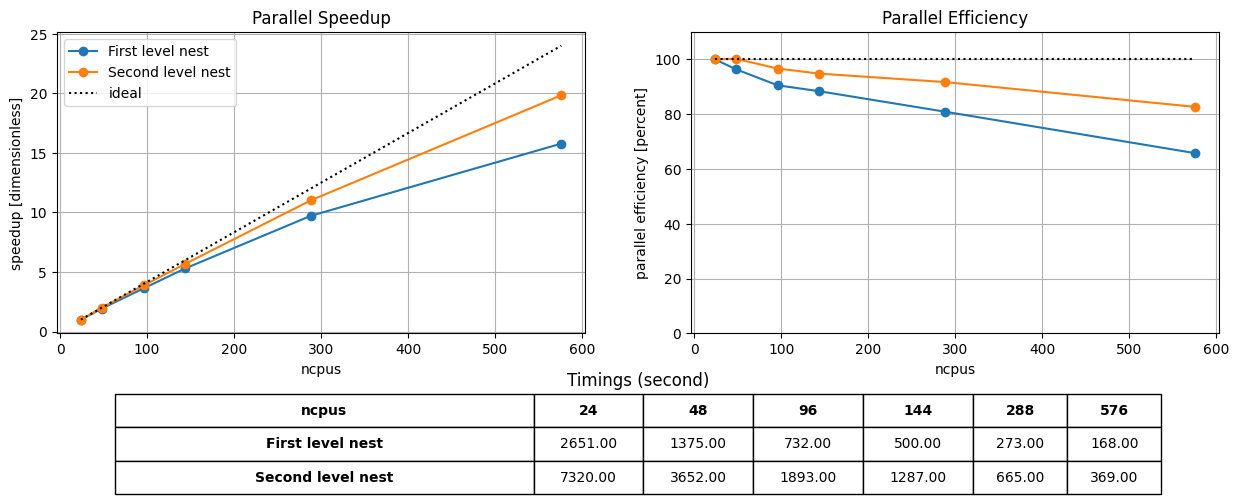

In [6]:
from access.profiling.metrics import tmax
profiling.plot_scaling_data(
    components=["cylc_tasks"],
    regions=[
        [
            "Lismore_d1100_GAL9_um_fcst_000_cycle20220226T0000Z", 
            "Lismore_d0198_RAL3P3_um_fcst_000_cycle20220226T0000Z"
        ]
    ], 
    metric=tmax,
    region_relabel_map={
        "Lismore_d1100_GAL9_um_fcst_000_cycle20220226T0000Z":"First level nest", 
        "Lismore_d0198_RAL3P3_um_fcst_000_cycle20220226T0000Z":"Second level nest",
    }
)

Here, we've performed a strong scaling study on ACCESS-rAM3 Regional Nesting Suite, which is based on the
UK Met Office's Unified Model (UM). The tests shown here uses UM v13.5 using the u-by395/access-ram3 tutorial configuration.
This configuration has two levels of nesting each with 450 by 450 grid cells in the latitude and longitude directions.
The first level of nesting is at 0.11 degrees resolution in both the latitude and longitude. The second level of nesting is at
0.0198 degrees resolution meaning the the second nest requires approximately 5.6 times as many time-steps for the same in-simulation
run-time. The two nesting levels also differ in that the second, high-resolution, nest explicitly resolves advection whereas this is
parameterized in the first level nest.

The execution of these two levels of nesting, alongside tasks that negotiate the interaction between the nests, is managed
using Cylc Rose.

The configuration is currently setup to run on the NCI "normal" queue, which consists of Cascade Lake nodes which each have 48 CPU
cores. By default, the u-by395/access-ram3 tutorial configuration uses 288 cores (6 nodes), and the scaling tests here are run 
between half a node (24 cores) up to 12 nodes (576 cores). The upper limit of 12 nodes was due to limitations on the number of
processes in the latitude direction of the domain for this configuration. The tests are run for 6 hours of in-simulation time, which
is representative of a typical chunk size used in practice.

In the figure, `ncpus` represents the number of CPU cores used at each nesting level. For example, `ncpus = 288` means that both 
first- and second-level nests are using 288 cores each.

Given this, when compared to the base value of 24 CPU cores, we achieve a speedup of approximately 20x at 576 cores (12 cascadelake 
nodes) for the more computationally expensive second-level nest - representing an efficinecy of approximately 81%. For the 
first-level nest, the speedup is approximately 16x corresponding to an efficiency of approx. 65%. The signiicant differences in
runtime and scaling efficinecy, can be attributed to the second-level nest having more timesteps and resolving advection explicitly.